# Spectral and Temporal Domain Consistency Analysis

This module thoroughly evaluates the realism and quality of synthetic EEG signals generated by your GAN in both temporal and frequency domains.

In [35]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy.signal import welch
import torch
import torch.nn as nn
import mne
import seaborn as sns

sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

# Device configuration
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


### Loading EEG data

This is to provide baseline distribution to asses GAN authenticity.

In [2]:
# Path configurations
models_path = "./../exploratory notebooks/models"
preprocessed_path = "./../data/preprocessed/"

In [3]:
# Robust EEG Data Loader for FID Module
def load_data(path, num_classes=2):
    subject_folders = [d for d in os.listdir(preprocessed_path) if os.path.isdir(os.path.join(preprocessed_path, d))]
    all_data = []
    all_labels = []

    for subj in subject_folders:
        fif_path = os.path.join(preprocessed_path, subj, "preprocessed_epochs-epo.fif")
        if os.path.exists(fif_path):
            epochs = mne.read_epochs(fif_path, preload=True)
            data = epochs.get_data()
            events = epochs.events


            labels_int = events[:, 2]
            unique_codes = np.unique(labels_int)

            # If only one event code is found, randomly split epochs into two classes.
            if len(unique_codes) < 2:
                print(f"Subject {subj}: Only one event code found. Randomly splitting epochs into two classes.")
                n_epochs = data.shape[0]
                # Randomly shuffle indices and split into two halves.
                indices = np.arange(n_epochs)
                np.random.shuffle(indices)
                labels_int = np.zeros(n_epochs, dtype=int)
                split_idx = n_epochs // 2
                labels_int[indices[split_idx:]] = 1
            else:
                # If more than two codes, take only the first two
                if len(unique_codes) > 2:
                    unique_codes = unique_codes[:2]
                mapping = {unique_codes[0]: 0, unique_codes[1]: 1}
                labels_int = np.vectorize(lambda x: mapping.get(x, 0))(labels_int)

            # One-hot encode the labels
            labels_onehot = np.zeros((len(labels_int), num_classes))
            labels_onehot[np.arange(len(labels_int)), labels_int] = 1

            all_data.append(data)
            all_labels.append(labels_onehot)
        else:
            print(f"File {fif_path} not found. Skipping subject {subj}.")

    if len(all_data) == 0:
        raise RuntimeError("No preprocessed data found.")

    # Concatenate data across subjects
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print("Loaded preprocessed EEG data shape:", all_data.shape)
    print("Loaded labels shape:", all_labels.shape)
    return all_data, all_labels

In [10]:
real_data, real_labels = load_data(preprocessed_path)
real_data = torch.from_numpy(real_data).float().to(device)
real_labels = torch.from_numpy(real_labels).float().to(device)

print("Real EEG data loaded. Shape:", real_data.shape)

Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub42/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub11/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub29/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CT

In [11]:
# EEG Generator from GAN notebook

class EEGGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_channels=63, target_signal_len=1001, num_classes=2):
        super().__init__()
        self.n_channels = n_channels
        self.target_signal_len = target_signal_len
        self.num_classes = num_classes

        self.base_length = target_signal_len // 8
        remainder = target_signal_len - (self.base_length * 8)

        self.fc = nn.Linear(latent_dim + num_classes, 256 * self.base_length)

        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=False),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=False),
            nn.ConvTranspose1d(64, n_channels, kernel_size=4, stride=2, padding=1, output_padding=remainder),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 256, self.base_length)
        out = self.deconv_blocks(x)
        return out

In [12]:
latent_dim = 100
n_channels = 63
target_signal_len = real_data.shape[2]
num_classes = 2

generator = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)
generator.load_state_dict(torch.load(os.path.join(models_path, "best_generator.pth"), map_location=device))
generator.eval()

print("Best GAN model loaded successfully.")

Best GAN model loaded successfully.


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_11834/2233600001.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(os.path.

In [13]:
# synthetic data

# Synthetic EEG embeddings
noise = torch.randn(real_data.size(0), latent_dim).to(device)
synthetic_data = generator(noise, real_labels)

In [14]:
# verification of loading
print(f"Real EEG shape: {real_data.shape}")
print(f"Synthetic EEG shape: {synthetic_data.shape}")

Real EEG shape: torch.Size([901, 63, 1001])
Synthetic EEG shape: torch.Size([901, 63, 1001])


##  Time-Domain Analysis

In [31]:
# statistical feature extraction

def compute_time_domain_features(data):
    data_np = data.cpu().numpy()
    mean_val = np.mean(data_np, axis=2)
    var_val = np.var(data_np, axis=2)
    kurtosis_val = kurtosis(data_np, axis=2)
    skewness_val = skew(data_np, axis=2)
    return mean_val, var_val, kurtosis_val, skewness_val

real_mean, real_var, real_kurt, real_skew = compute_time_domain_features(real_data)
synthetic_mean, synthetic_var, synthetic_kurt, synthetic_skew = compute_time_domain_features(synthetic_data.detach())

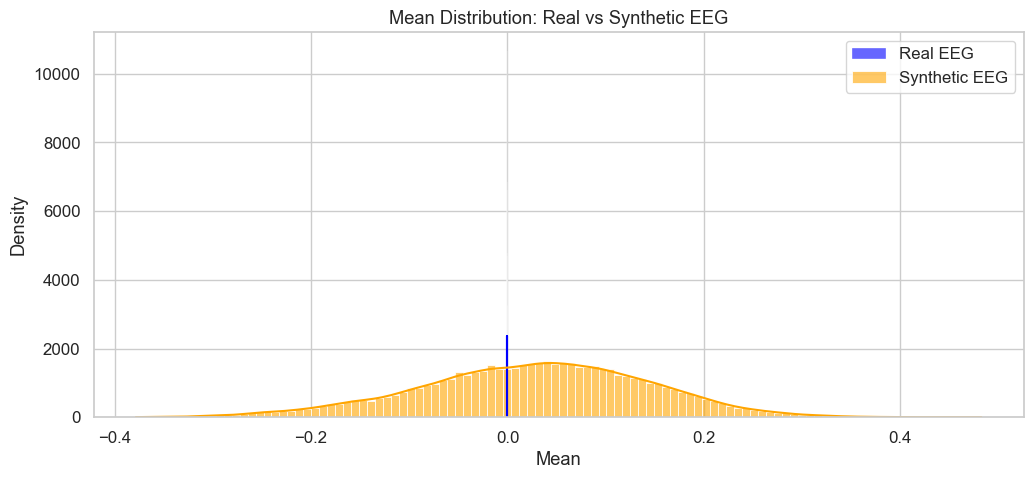

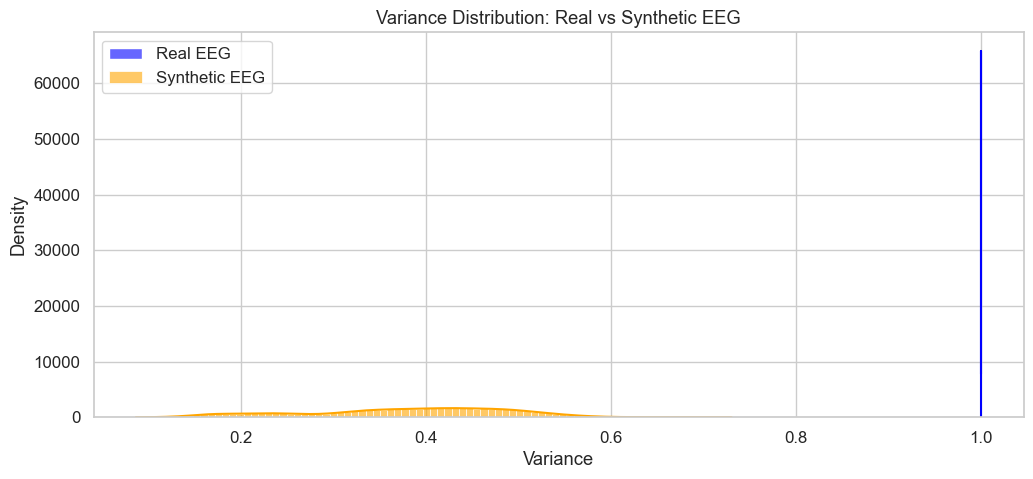

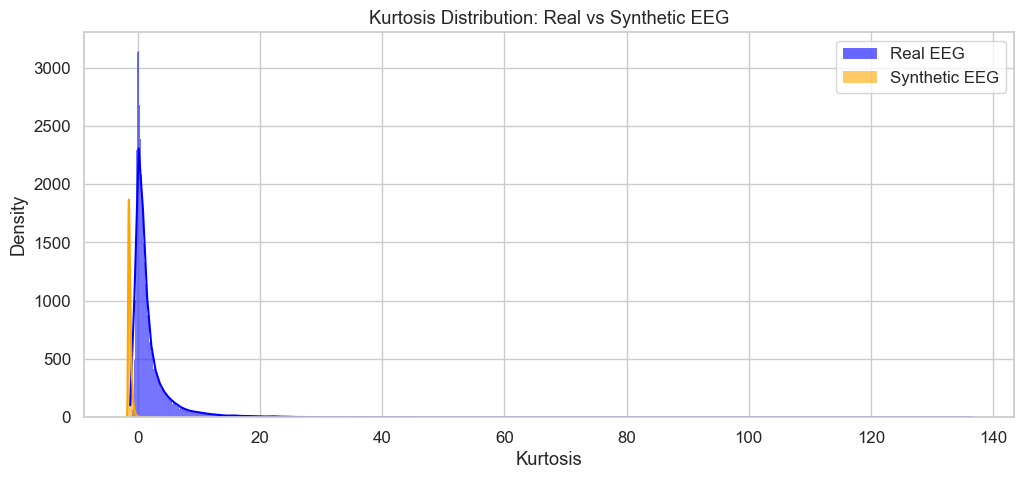

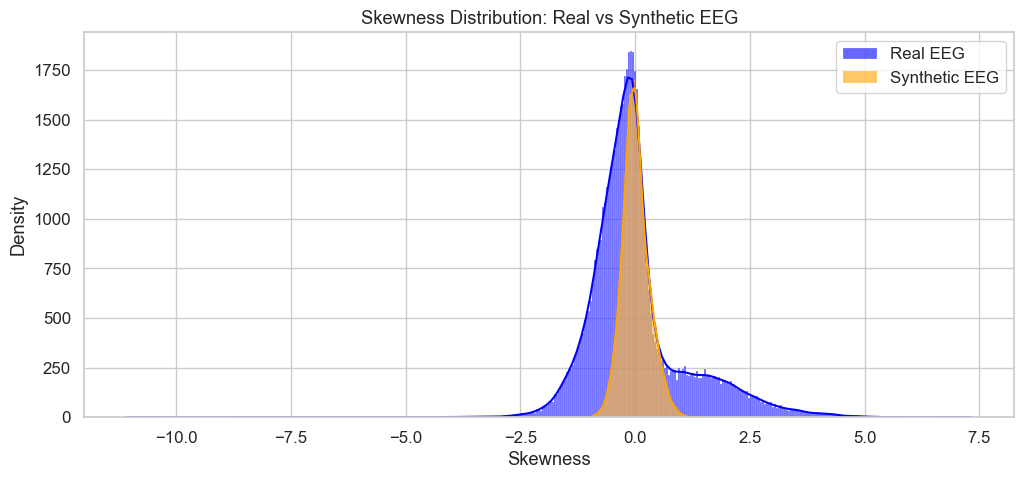

In [18]:
# statistical comparison and heatmap
def plot_statistical_comparison(real_feat, synth_feat, feat_name):
    plt.figure(figsize=(12,5))
    sns.histplot(real_feat.flatten(), kde=True, color='blue', label='Real EEG', alpha=0.6)
    sns.histplot(synth_feat.flatten(), kde=True, color='orange', label='Synthetic EEG', alpha=0.6)
    plt.title(f"{feat_name} Distribution: Real vs Synthetic EEG")
    plt.xlabel(feat_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot for each statistic
plot_statistical_comparison(real_mean, synthetic_mean, "Mean")
plot_statistical_comparison(real_var, synthetic_var, "Variance")
plot_statistical_comparison(real_kurt, synthetic_kurt, "Kurtosis")
plot_statistical_comparison(real_skew, synthetic_skew, "Skewness")

#### Analysis of Statistical Feature Distributions (Mean, Variance, Kurtosis, Skewness)

**Interpretation**
- _Mean and variance:_ Ideally distributions of synthetic and real EEG should overlap closely. Significant deviations indicate the GAN isn’t accurately capturing the fundamental EEG statistics.
- _Kurtosis and Skewness:_ Kurtosis (peakedness) and skewness (asymmetry) should be similar, indicating realistic temporal EEG signal dynamics.

#### Analysis of Current plots
- Mean and variance
    - There are large discrepancies, REAL EEG has a very narrow mean distribution around zero, but Synthetic has broader variance, indicating synthetic EEG mean drift.
    - For variance Distribution, Real EEG variance distribution is sharply peaked at a single point (1.0), synthetic EEG has broader and smaller variance. We do think this is because of amplitude accuracy
- Kurtosis & Skewness:
    - These both have moderate to good overlap signifying good capture of waveform shapes

**In general**, this does signifies that our GAN model need more improvements in replicating mean and variance

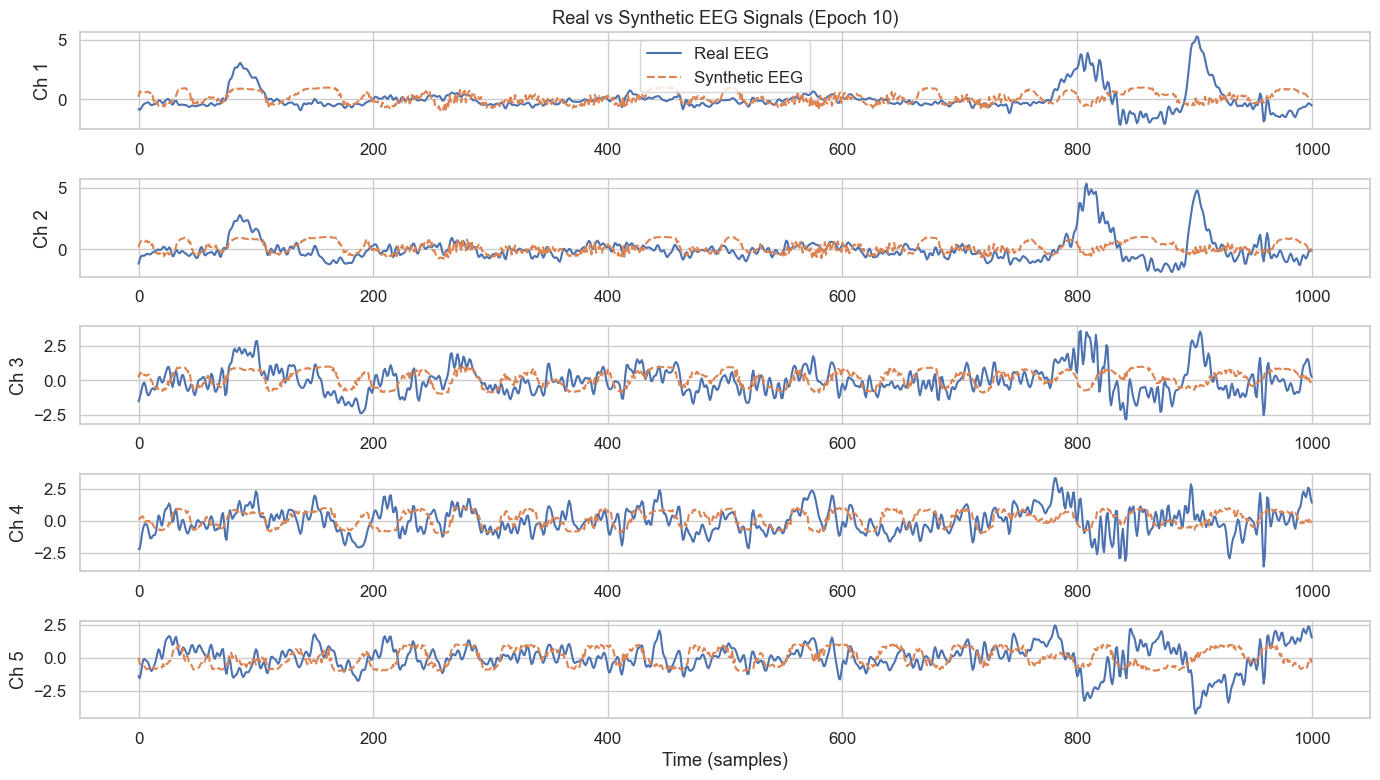

In [21]:
# Time domain waveform visualisation

def plot_waveforms(real, synthetic, epoch_idx, channels=5):
    plt.figure(figsize=(14, 8))
    for ch in range(channels):
        plt.subplot(channels, 1, ch+1)
        plt.plot(real[epoch_idx, ch].cpu(), label="Real EEG")
        plt.plot(synthetic[epoch_idx, ch].detach().cpu(), linestyle='--', label="Synthetic EEG")
        plt.ylabel(f"Ch {ch+1}")
        if ch == 0:
            plt.title(f"Real vs Synthetic EEG Signals (Epoch {epoch_idx})")
        if ch == channels - 1:
            plt.xlabel("Time (samples)")
        if ch == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

plot_waveforms(real_data, synthetic_data, epoch_idx=10, channels=5)

#### Analysis of Time-Domain Waveform Comparison (Epoch Visualization)
**Interpretation**
- Realistic synthetic EEG signals must closely mimic real EEG signals visually in terms of waveform structure, amplitude fluctuations, and temporal dynamics.

#### Analysis of current:
- Overall good overlapping with occasional mismatch.

**This plot verifies our doubts about amplitude inconsistencies**

### Frequency-Domain Analysis

In [23]:
# Compute PSD
def compute_psd(data, sfreq=200):
    data_np = data.cpu().numpy()
    psds, freqs = welch(data_np, sfreq, nperseg=256, axis=2)
    return psds, freqs

real_psds, freqs = compute_psd(real_data)
synthetic_psds, _ = compute_psd(synthetic_data.detach())

real_psds shape: (901, 63, 129)
synthetic_psds shape: (901, 63, 129)
freqs shape: (129,)


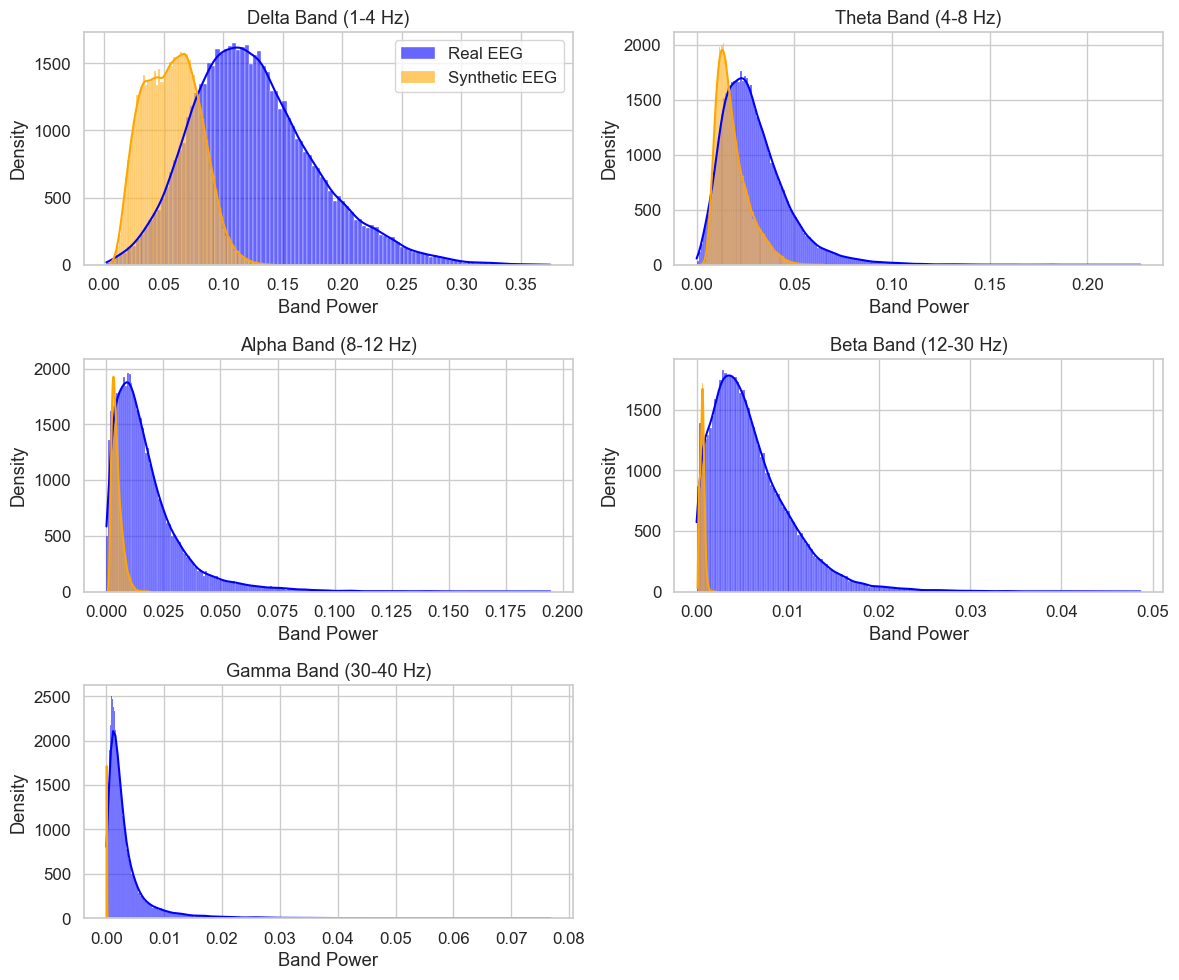

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

# Define frequency bands
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 40)
}

# Corrected PSD computation function
def compute_psd(data, sfreq=200):
    epochs, channels, samples = data.shape
    psds = []
    for epoch in range(epochs):
        epoch_psds = []
        for ch in range(channels):
            freqs, psd = welch(data[epoch, ch, :].cpu().detach().numpy(), fs=sfreq, nperseg=256)
            epoch_psds.append(psd)
        psds.append(epoch_psds)
    psds = np.array(psds)  # shape: (epochs, channels, frequencies)
    return psds, freqs

# Band power calculation for specific bands
def band_power(psds, freqs, band):
    fmin, fmax = band
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.mean(psds[:, :, idx_band], axis=-1)  # averaged over frequency dimension

# Plot band power comparison
def plot_band_power_comparison(real_psds, synthetic_psds, freqs, bands):
    plt.figure(figsize=(12, 10))

    for idx, (band_name, freq_range) in enumerate(bands.items(), 1):
        real_band = band_power(real_psds, freqs, freq_range)
        synth_band = band_power(synthetic_psds, freqs, freq_range)

        plt.subplot(3, 2, idx)
        sns.histplot(real_band.flatten(), kde=True, label="Real EEG", color='blue', alpha=0.6)
        sns.histplot(synth_band.flatten(), kde=True, label="Synthetic EEG", color='orange', alpha=0.6)
        plt.title(f"{band_name} Band ({freq_range[0]}-{freq_range[1]} Hz)")
        plt.xlabel("Band Power")
        plt.ylabel("Density")
        if idx == 1:
            plt.legend()

    plt.tight_layout()
    plt.show()

# Recalculate PSD for real and synthetic data using corrected function
real_psds, freqs = compute_psd(real_data)
synthetic_psds, _ = compute_psd(synthetic_data)

# Verify shapes explicitly (correct output: (epochs, channels, frequencies))
print(f"real_psds shape: {real_psds.shape}")           # (epochs, channels, frequencies)
print(f"synthetic_psds shape: {synthetic_psds.shape}") # (epochs, channels, frequencies)
print(f"freqs shape: {freqs.shape}")                   # (frequencies,)

# Plot band power comparison distributions
plot_band_power_comparison(real_psds, synthetic_psds, freqs, bands)

#### Analysis of Band Power Distribution Analysis (Frequency Domain)

**Interpretation**
- EEG frequency bands (Delta, Theta, Alpha, Beta, Gamma) should exhibit similar distributions in synthetic EEG as in real EEG for realistic frequency-domain representation.

#### Analysis on current plots
- Delta Band: Partial overlap with some clear distributional shift, indicating underestimation of slow-wave EEG power by synthetic data.
- Theta, Alpha, Beta Bands: Limited overlap and narrower distribution in synthetic EEG—GAN struggles to accurately capture higher-frequency power distributions and overall frequency content realism.
- Gamma Band: Minimal overlap, highlighting significant limitations of synthetic EEG at high frequencies. GAN doesn’t effectively reproduce higher-frequency EEG dynamics.

**Okay these ones show clear issues with frequency domain realism. Frequency content at higher bands is insufficiently captured and needs significant improvement.**

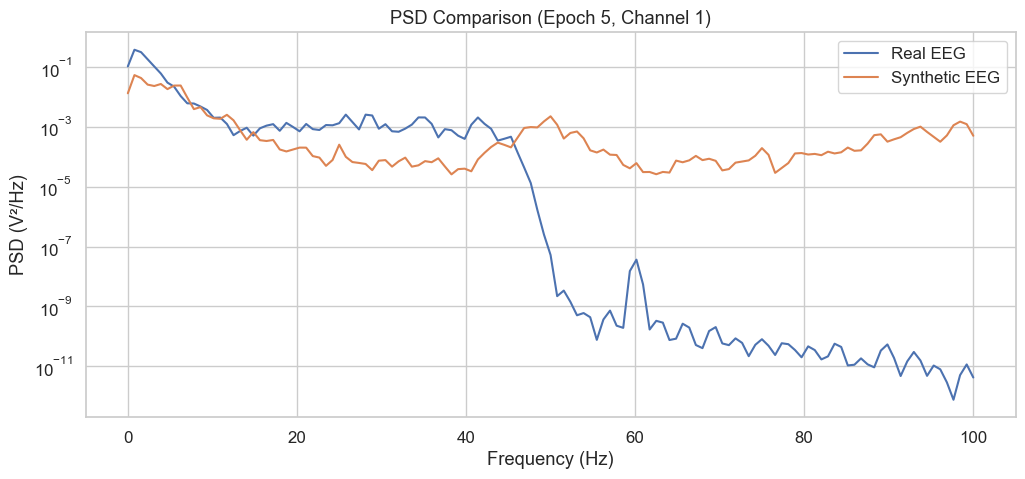

In [28]:
# PSD Visualization for sample Epoch

def plot_psd_comparison(real_psd, synth_psd, freqs, epoch_idx=0, ch_idx=0):
    plt.figure(figsize=(12,5))
    plt.semilogy(freqs, real_psd[epoch_idx, ch_idx], label='Real EEG')
    plt.semilogy(freqs, synth_psd[epoch_idx, ch_idx], label='Synthetic EEG')
    plt.title(f"PSD Comparison (Epoch {epoch_idx}, Channel {ch_idx+1})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V²/Hz)")
    plt.legend()
    plt.show()

plot_psd_comparison(real_psds, synthetic_psds, freqs, epoch_idx=5, ch_idx=0)

#### Analysis of PSD comparison

**Interpretation**
- close overlapping, signifies synthetic EEG has a realistic frequency content and power distributions across all EEG frequencies.

#### Analysis on current plot
- Good for low frequencies (below ~20 Hz), but significant deviation at higher frequencies (>30 Hz)

### Heatmap and statistical Similarity

In [36]:
# heatmap visualization function
def plot_similarity_heatmap(real_features, synthetic_features, feature_names):
    combined_feats = np.vstack([real_features, synthetic_features])
    similarity_matrix = np.corrcoef(combined_feats)

    plt.figure(figsize=(10, 8))

    # Generate clear heatmap with annotations
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=feature_names, yticklabels=feature_names,
                linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 10})

    plt.title("Heatmap of Statistical Similarity (Real vs Synthetic EEG)", fontsize=16, pad=12)
    plt.xticks(rotation=45, ha="right", fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    plt.show()

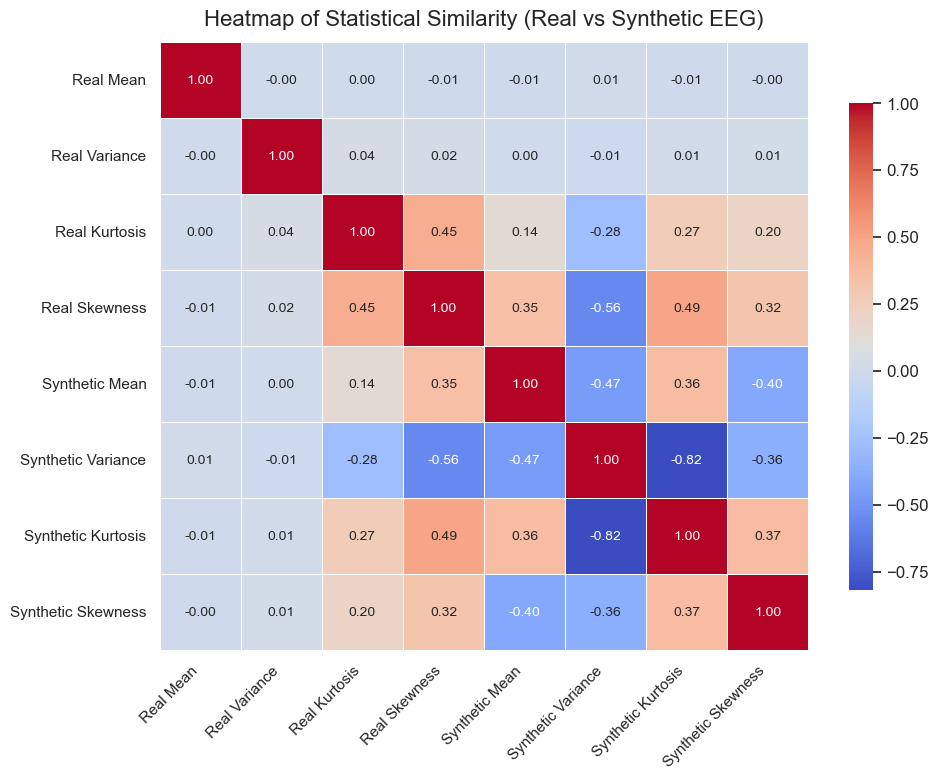

In [37]:
# Prepare features clearly
feature_labels = [
    'Real Mean', 'Real Variance', 'Real Kurtosis', 'Real Skewness',
    'Synthetic Mean', 'Synthetic Variance', 'Synthetic Kurtosis', 'Synthetic Skewness'
]

# Flatten features across epochs and channels for robust correlation
real_feats = np.vstack([
    real_mean.flatten(),
    real_var.flatten(),
    real_kurt.flatten(),
    real_skew.flatten()
])

synthetic_feats = np.vstack([
    synthetic_mean.flatten(),
    synthetic_var.flatten(),
    synthetic_kurt.flatten(),
    synthetic_skew.flatten()
])

# Call enhanced visualization function
plot_similarity_heatmap(real_feats, synthetic_feats, feature_labels)

#### Analysis of Heatmap of Statistical Similarity (Real vs. Synthetic EEG)

**Interpretability**
- correlations between statistical features (Mean, Variance, Kurtosis, and Skewness) for both real and synthetic EEG data.

#### Analysis for the current plot
- Mean and variance have low correlation
- Kurtosis and skewness are much more correlated for real and synthetic data